In [2]:
import torch
import os
import matplotlib.pyplot as plt 
import time
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from model import VGG,CNN
import torch.nn as nn
import numpy as np
import random
import cv2
from util import get_file_list,imgDataset,detect_face
import pandas as pd
import matplotlib.pyplot as plt 
import copy
import pickle

embedding_size=4096
batch_size=16

result_path='./result'
model_path=os.path.join(result_path,'best_model.pth')
record_path=os.path.join(result_path,'record.csv')
vgg_face_2_training_face='./data/vggface2_train_face_notmask/'
lfw_path='./data/lfw/'
lfw_pair_train_file='./data/pairsDevTrain.txt'
lfw_pair_test_file='./data/pairsDevTest.txt'
lfw_pair_file='./data/pairs.txt'
dirs=sorted(os.listdir(vgg_face_2_training_face))
n_classes=len(dirs)



In [ ]:
image_list,label_list=get_file_list(vgg_face_2_training_face)


In [4]:
classifier=CNN(embedding_size,n_classes)
classifier.load_state_dict(torch.load(model_path))
featureNet=classifier.backbone
featureNet.eval()


VGG(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
evaluate_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

vgg_face_2=imgDataset(file_list=image_list,label_list=label_list,transform=evaluate_transform,image_size=(224,224))
evaluate_dataloader = DataLoader(vgg_face_2, batch_size=batch_size)


In [ ]:
total_acc=0
classifier=classifier.cuda()
with torch.no_grad():
    pbar=tqdm(evaluate_dataloader)
    for batch in pbar:
        batch_X,batch_y=batch
        batch_X=batch_X.cuda()
        batch_y=batch_y.cuda()
        val_pred = classifier(batch_X.cuda())
        batch_acc=np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == batch_y.cpu().numpy())/(batch_size)
        total_acc+=batch_acc
        pbar.set_description("Evaluate")
        pbar.set_postfix(acc=batch_acc)
        pbar.update()

eval_acc=total_acc/len(evaluate_dataloader)
print('Evaluate accuracy:{}'.format(eval_acc))


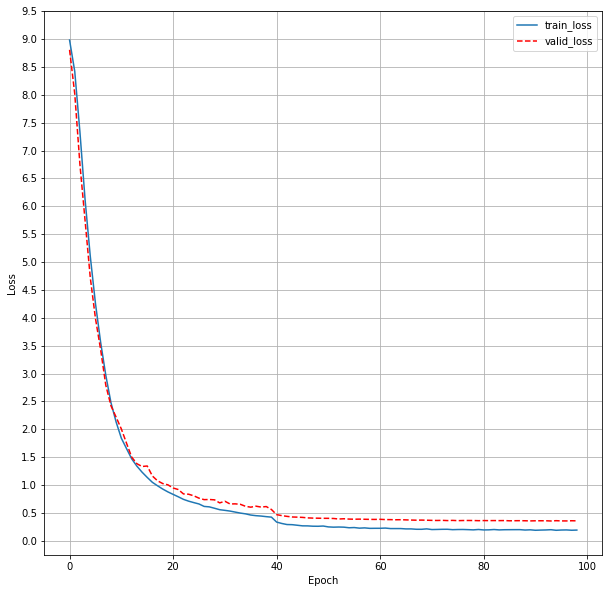

In [12]:
training_record=pd.read_csv(record_path)
plt.figure(figsize=(10,10))
plt.plot(training_record['epoch'].to_list(),training_record['train_loss'].to_list(),label='train_loss')
plt.plot(training_record['epoch'].to_list(),training_record['valid_loss'].to_list(),'r--',label='valid_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([i/2 for i in range(20)])
plt.grid()
plt.show()

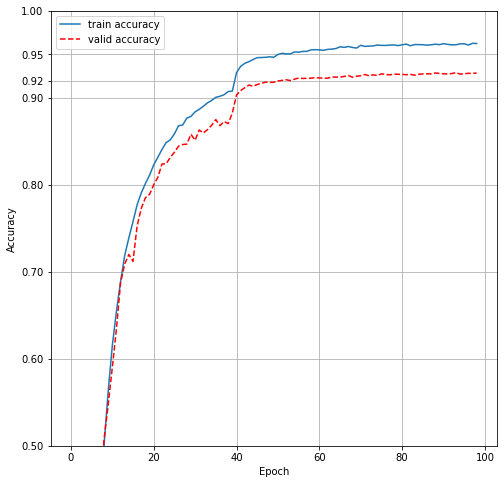

In [13]:
plt.figure(figsize=(8,8))
plt.plot(training_record['epoch'].to_list(),training_record['train_acc'].to_list(),label='train accuracy')
plt.plot(training_record['epoch'].to_list(),training_record['valid_acc'].to_list(),'r--',label='valid accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.yticks([0.5,0.6,0.7,0.8,0.9,0.92,0.95,1.0])

plt.grid()
plt.show()

In [5]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [6]:
lfw_file_list,_=get_file_list(lfw_path)
lfw_file_idx={}
for i,file_path in enumerate(lfw_file_list):
    lfw_file_idx[file_path]=i


In [7]:
def read_lfw(lfw_file_list,detector,img_size):
    result=[]
    error_path=[]
    pbar=tqdm(lfw_file_list)
    for file_path in pbar:
        img=cv2.imread(file_path)
        face,_=detect_face(img,detector)
        if face is img:
            error_path.append(file_path)
        face=cv2.resize(face,img_size)
        result.append(face)
    return result,error_path

lfw_faces,error_path=read_lfw(lfw_file_list,face_cascade,(224,224))

In [8]:
evaluate_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
class faceData(Dataset):
    def __init__(self,face_data,transform):
        self.data=face_data
        self.transform=transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.transform(self.data[idx])

lfw_data=faceData(lfw_faces,evaluate_transform)
lfw_dataloader = DataLoader(lfw_data, batch_size=batch_size)

In [9]:
featureNet.eval()
featureNet=featureNet.cuda()
faceFeatures=[]
with torch.no_grad():
    pbar=tqdm(lfw_dataloader)
    for batch in pbar:
        batch=batch.cuda()
        result=featureNet(batch)
        faceFeatures.append(torch.nn.functional.normalize(result))
faceFeatures=torch.cat(faceFeatures)

In [10]:
def get_lfw_pair(lfw_path,pair_file_path):
    pair_file=open(pair_file_path,'r')
    data=pair_file.readline().replace('\n','').split('\t')
    fold_num=int(data[0])
    same_pair_num=int(data[1])
    same_pair=[]
    different_pair=[]
    for _ in range(fold_num):
        for _ in range(same_pair_num):
            line=pair_file.readline()
            line=line.replace('\n','')
            line=line.split('\t')
            path_1=os.path.join(lfw_path,line[0])
            path_2=os.path.join(lfw_path,line[0])
            path_1=os.path.join(path_1,'%s_%04d.jpg'%(line[0],int(line[1])))
            path_2=os.path.join(path_2,'%s_%04d.jpg'%(line[0],int(line[2])))
            same_pair.append([path_1,path_2])
        for _ in range(same_pair_num):
            line=pair_file.readline()
            line=line.replace('\n','')
            line=line.split('\t')
            path_1=os.path.join(lfw_path,line[0])
            path_2=os.path.join(lfw_path,line[2])
            path_1=os.path.join(path_1,'%s_%04d.jpg'%(line[0],int(line[1])))
            path_2=os.path.join(path_2,'%s_%04d.jpg'%(line[2],int(line[3])))
            different_pair.append([path_1,path_2]) 
    pair_file.close()
    return same_pair,different_pair

same_pair,different_pair=get_lfw_pair(lfw_path=lfw_path,pair_file_path=lfw_pair_file)

In [11]:
same_pair_dist=[]
pdist = nn.PairwiseDistance(p=2)
for file_pair in same_pair:
    idx1=lfw_file_idx[file_pair[0]]
    idx2=lfw_file_idx[file_pair[1]]
    data_1=torch.unsqueeze(faceFeatures[idx1],0)
    data_2=torch.unsqueeze(faceFeatures[idx2],0)
    same_pair_dist.append(pdist(data_1,data_2).item())

different_pair_dist=[]
for file_pair in different_pair:
    idx1=lfw_file_idx[file_pair[0]]
    idx2=lfw_file_idx[file_pair[1]]
    data_1=torch.unsqueeze(faceFeatures[idx1],0)
    data_2=torch.unsqueeze(faceFeatures[idx2],0)
    different_pair_dist.append(pdist(data_1,data_2).item())


    

In [7]:
threshold=1.25


TP=0
TN=0
for data in same_pair_dist:
    if data<threshold:
        TP+=1

for data in different_pair_dist:
    if data>threshold:
        TN+=1

TP=TP/len(same_pair_dist)
TN=TN/len(different_pair_dist)
FN=1-TP
FP=1-TN

conf_mtrx_df=pd.DataFrame([[TP,FP],[FN,TN]])
print('accuracy:{}'.format((TP+TN)/(TP+FP+FN+TN)))
precision=TP/(TP+FP)
recall=TP/(TP+FN)
print('precision:{}'.format(precision))
print('recall:{}'.format(recall))
print('f1 score:{}'.format(2*precision*recall/(precision+recall)))



conf_mtrx_df.rename(columns={0: 'target(1)',1: 'target(0)'}, index={0: 'predict(1)',1: 'predict(0)'})


accuracy:0.8103333333333333
precision:0.8074636723910172
recall:0.815
f1 score:0.8112143331121433


,target(1),target(0)
predict(1),0.815,0.194333
predict(0),0.185,0.805667


In [13]:
with open('lfw_same_result.pkl', 'wb') as f:
    pickle.dump(same_pair_dist, f)
with open('lfw_different_result.pkl', 'wb') as f:
    pickle.dump(different_pair_dist, f)